In [ ]:
%pip install huggingface_hub

# Loading libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Loading the dataset

Dataset used [MultiClass Sentiment Analysis](https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset)

In [2]:
splits = {'train': 'train_df.csv', 'validation': 'val_df.csv', 'test': 'test_df.csv'}
train = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["train"])
test = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["test"])
val = pd.read_csv("hf://datasets/Sp1786/multiclass-sentiment-analysis-dataset/" + splits["validation"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## PreProcess the data

In [3]:
labels = {0:"Negative" , 1:"Neutral" , 2:"Positive"}  #Encode the labels

def datasetprocess(df):
    df.drop(columns=["id" , "sentiment"] , inplace=True)
    df.drop_duplicates(subset=["text"] , inplace=True)
    df.dropna(axis=0 , inplace=True)
    df.reset_index(drop=True , inplace=True)

    df["text"] = df["text"].astype(str)
    df["label"] = df["label"].astype(int)

    df.head(5)

datasetprocess(train)
datasetprocess(test)
datasetprocess(val)

# Define the hyper-parameters

In [4]:
vocab_size = 5000
lr = 1e-4
batch_size = 32
epochs = 10

# Defining the text vectorizer

In [18]:
@tf.keras.saving.register_keras_serializable()
class CustomTextVectorization(tf.keras.layers.TextVectorization): #Custom TextVectorization Layer
    def get_config(self):
        config = super().get_config()
        return config

encoder = CustomTextVectorization(max_tokens=vocab_size)
encoder.adapt(train["text"].values)

# Model

In [19]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer=tf.keras.optimizers.Adam(lr),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_text_vectorization_  (None, None)              0         
 1 (CustomTextVectorization                                      
 )                                                               
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          320000    
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)               

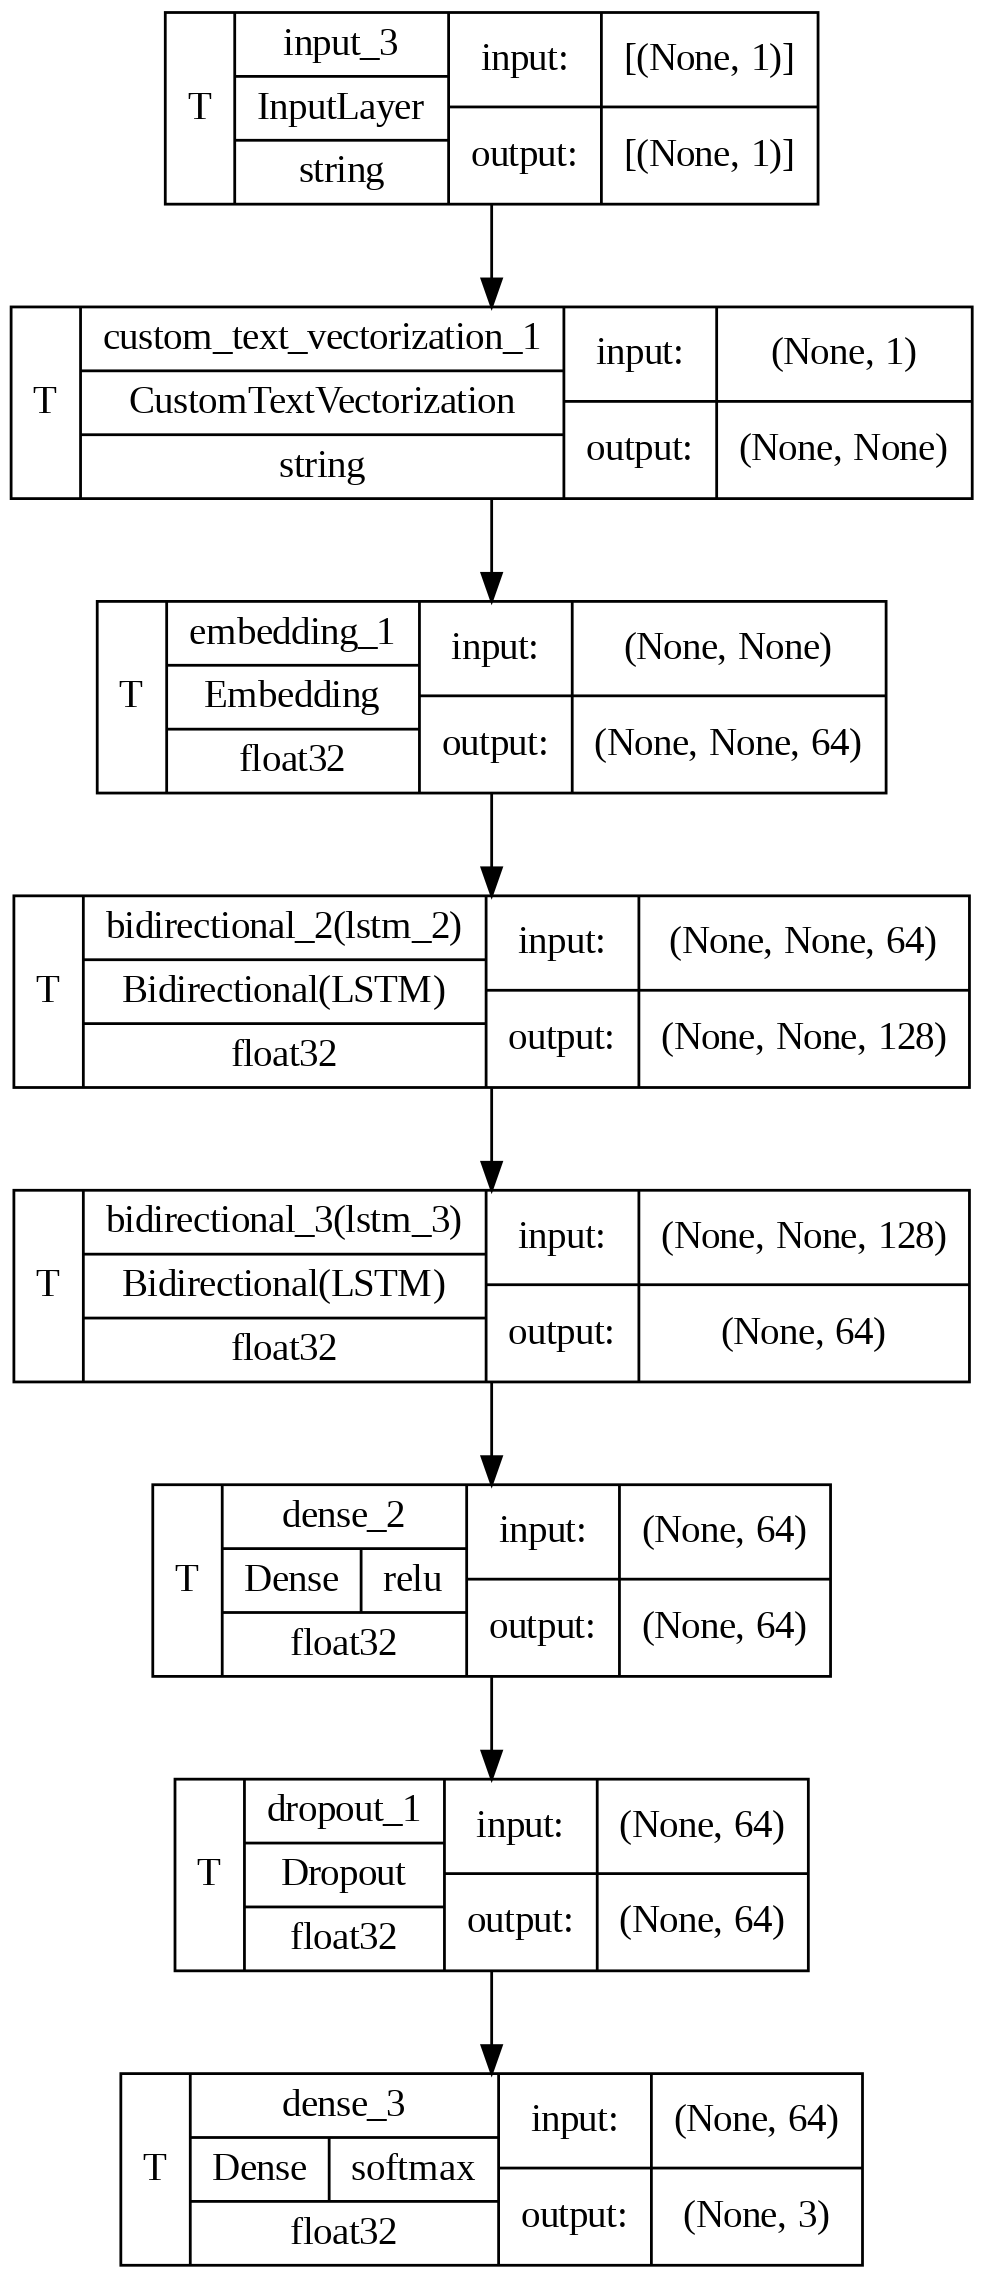

In [28]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

# Training the model

In [21]:
history = model.fit(train["text"].values ,train["label"].values,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(val["text"].values , val["label"].values),
                    validation_steps=30
                    )

Epoch 1/10
976/976 [==============================] - 67s 52ms/step - loss: 0.9942 - accuracy: 0.4989 - val_loss: 0.8645 - val_accuracy: 0.6167
Epoch 2/10
976/976 [==============================] - 31s 32ms/step - loss: 0.7897 - accuracy: 0.6639 - val_loss: 0.7825 - val_accuracy: 0.6562
Epoch 3/10
976/976 [==============================] - 31s 32ms/step - loss: 0.7238 - accuracy: 0.7044 - val_loss: 0.7680 - val_accuracy: 0.6604
Epoch 4/10
976/976 [==============================] - 30s 30ms/step - loss: 0.6886 - accuracy: 0.7228 - val_loss: 0.7607 - val_accuracy: 0.6667
Epoch 5/10
976/976 [==============================] - 29s 29ms/step - loss: 0.6603 - accuracy: 0.7396 - val_loss: 0.7629 - val_accuracy: 0.6500
Epoch 6/10
976/976 [==============================] - 29s 30ms/step - loss: 0.6327 - accuracy: 0.7511 - val_loss: 0.7679 - val_accuracy: 0.6594
Epoch 7/10
976/976 [==============================] - 30s 31ms/step - loss: 0.6083 - accuracy: 0.7665 - val_loss: 0.7785 - val_accuracy:

In [22]:
model.save("classifier(5k tokens).keras")

In [23]:
test_loss, test_acc = model.evaluate(x= test["text"].values , y= test["label"].values)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

163/163 [==============================] - 2s 10ms/step - loss: 0.8206 - accuracy: 0.6622
Test Loss: 0.8205933570861816
Test Accuracy: 0.6622478365898132


# Testing the Model

In [24]:
# predict on a sample text without padding.

sample_text1 = ('The movie was ehhh.')
sample_text2 = ('The movie was good.')
sample_text3 = ('The movie was bad.')
predictions1 = model.predict(np.array([sample_text1]))
predictions2 = model.predict(np.array([sample_text2]))
predictions3 = model.predict(np.array([sample_text3]))

print(labels[tf.argmax(predictions1[0]).numpy()])
print(labels[tf.argmax(predictions2[0]).numpy()])
print(labels[tf.argmax(predictions3[0]).numpy()])

1/1 [==============================] - 0s 21ms/step
Neutral
Positive
Negative


# Try the model

Run all the above cells before running this cell


In [27]:
def analyze(text : str , filepath : str , labels : dict) -> str:

    try:
      model = tf.keras.models.load_model(filepath , custom_objects={'CustomTextVectorization': CustomTextVectorization})
    except:
        print("Error Loading Model")
        return

    prediction = model.predict(np.asarray([text]))

    return labels[tf.argmax(prediction[0]).numpy()]


input_text = input("Enter sentance: ")

labels = {0:"Negative" , 1:"Neutral" , 2:"Positive"}

model_path = "classifier(5k tokens).keras"

output = analyze(input_text , model_path , labels)

print("Predicted Sentiment is : ",output)

Enter sentance: This is worst service i have ever had.


1/1 [==============================] - 4s 4s/step
Predicted Sentiment is :  Negative
